In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### import packages and data

In [ ]:
!pip install aif360

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 1.1 MB/s eta 0:00:00


In [ ]:
# !pip install 'aif360[Reductions]'

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from aif360.sklearn.inprocessing import AdversarialDebiasing
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'


In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

In [ ]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

# fetch dataset
heart_disease = fetch_ucirepo(id=45)

# data (as pandas dataframes)
X_heart = heart_disease.data.features
y_heart = heart_disease.data.targets

In [ ]:
heart = X_heart
heart['num'] = y_heart['num']

In [ ]:
heart.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0
dtype: int64

In [ ]:
# replace missing values with mean
heart.fillna(heart.mean(), inplace=True)

In [ ]:
heart['num'] = heart['num'].map(lambda x: 1 if x >=1 else 0)

In [ ]:
heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


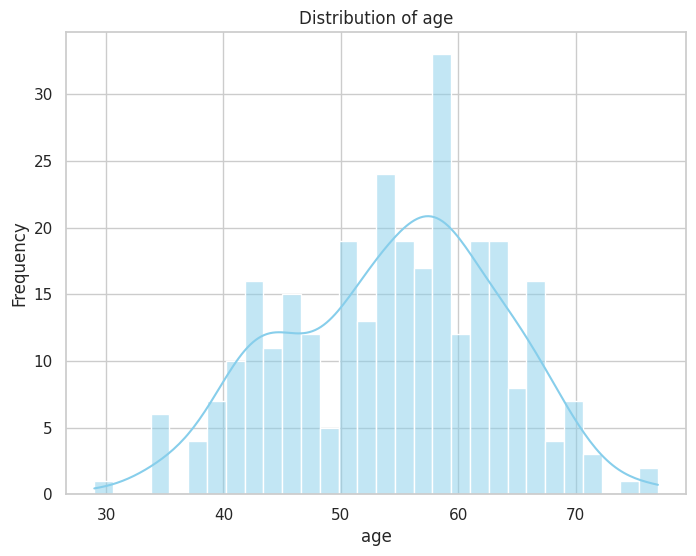

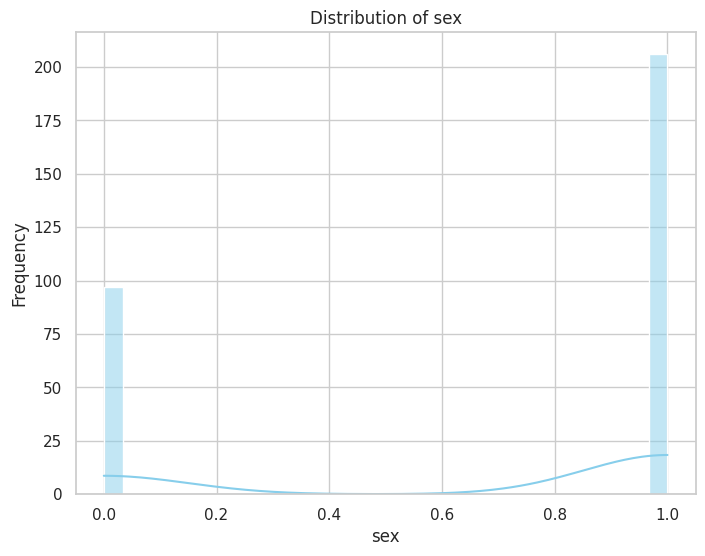

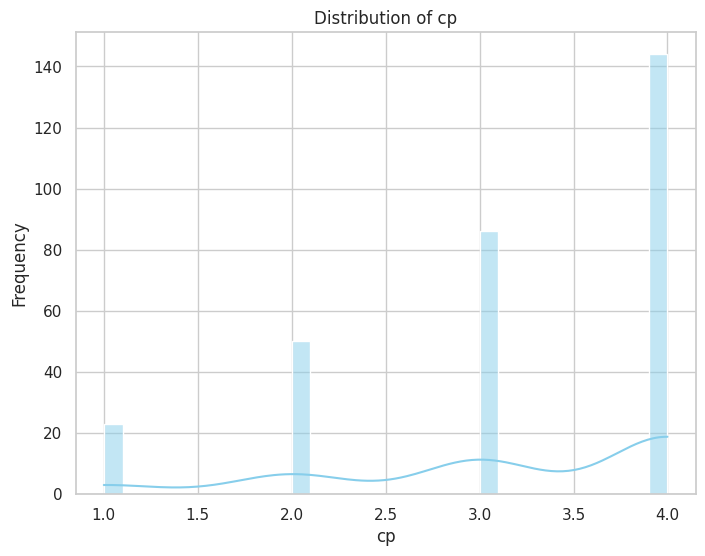

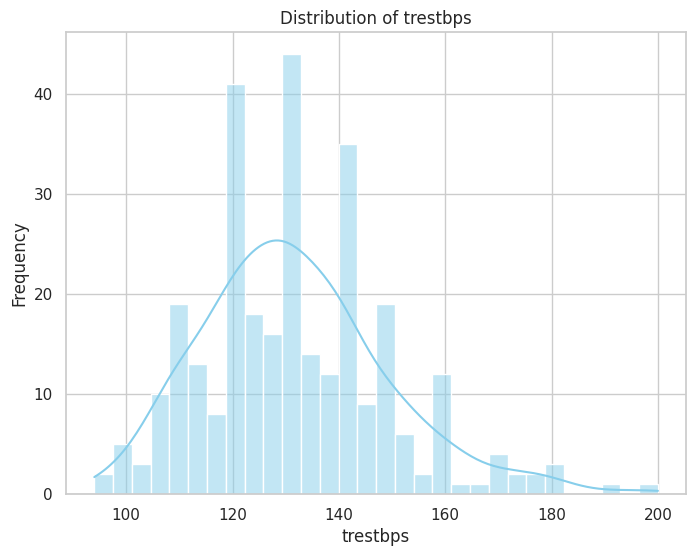

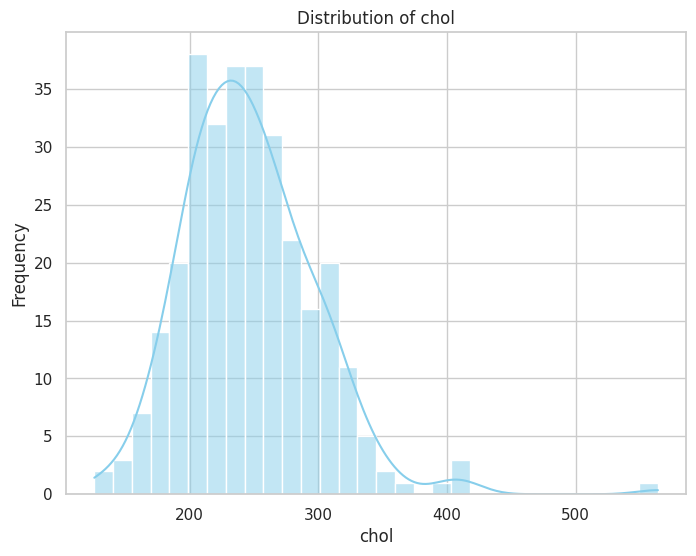

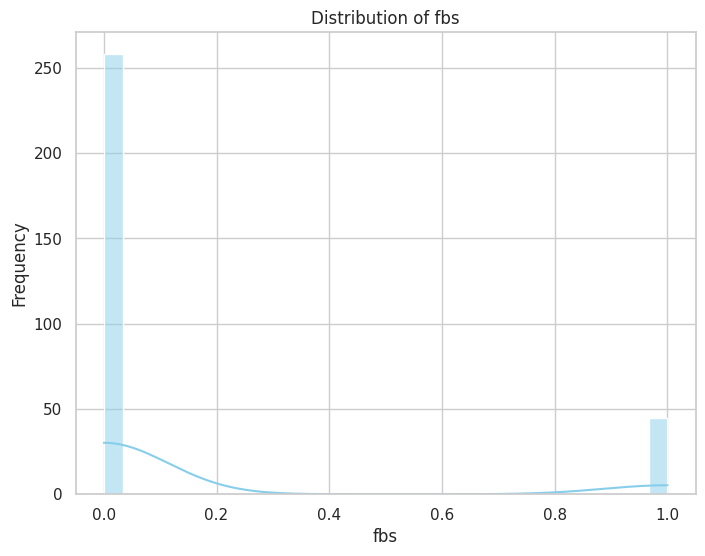

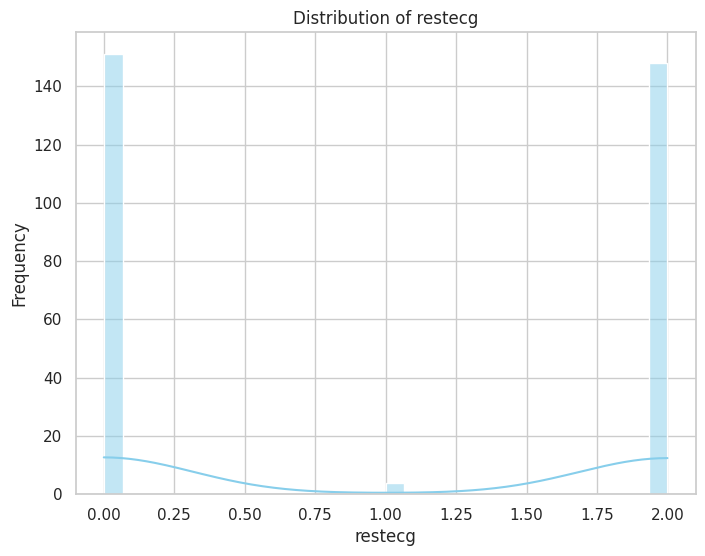

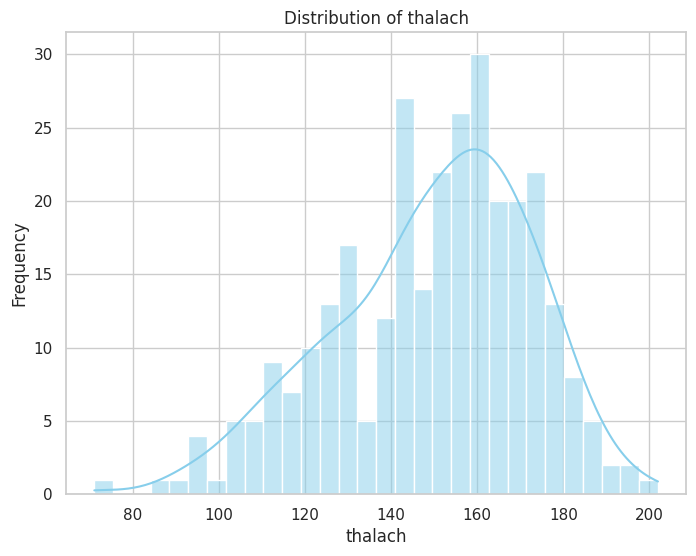

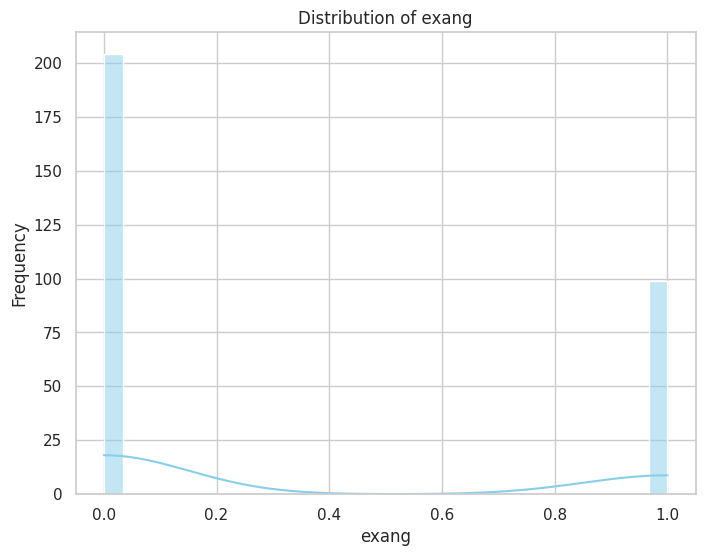

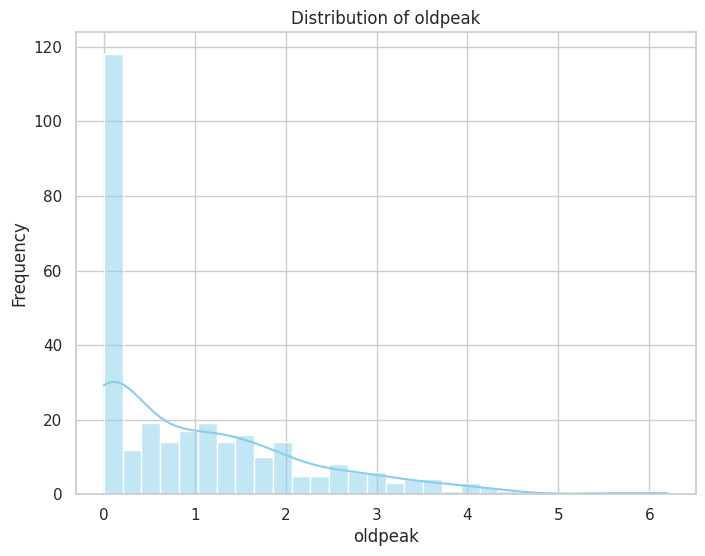

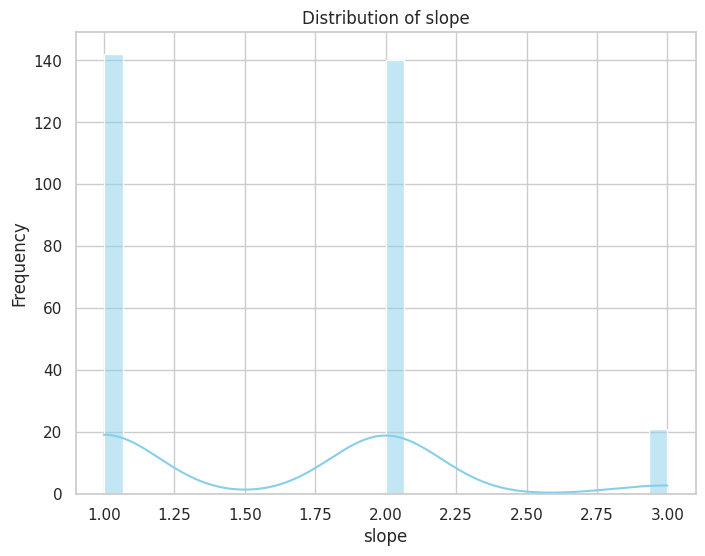

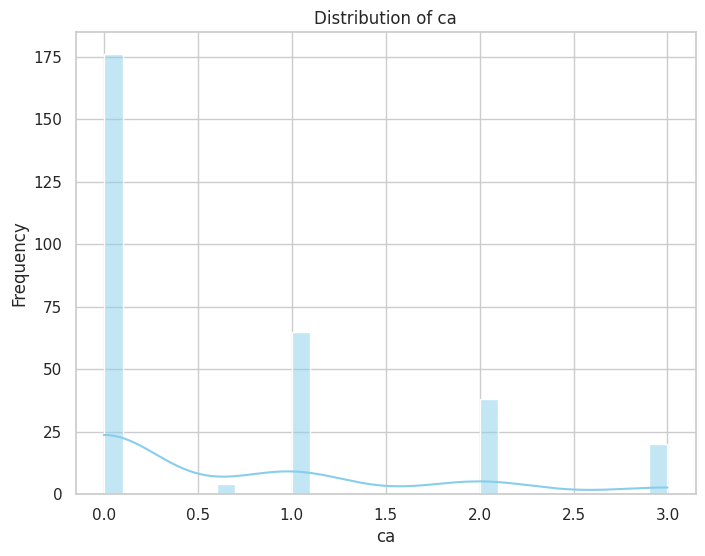

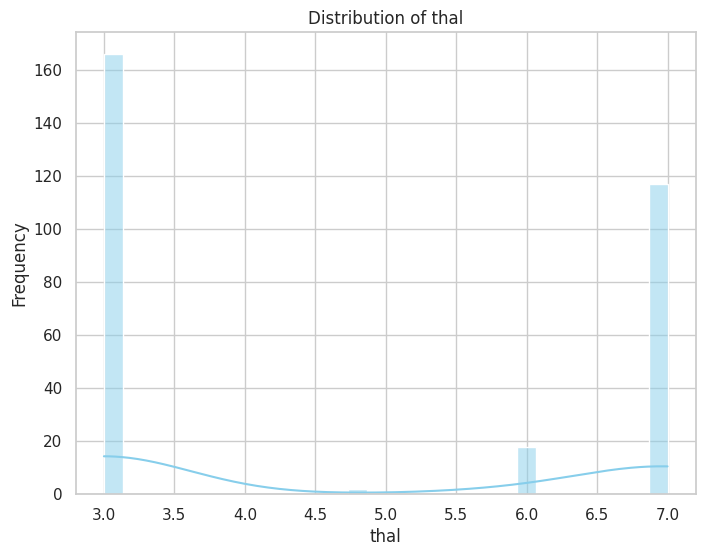

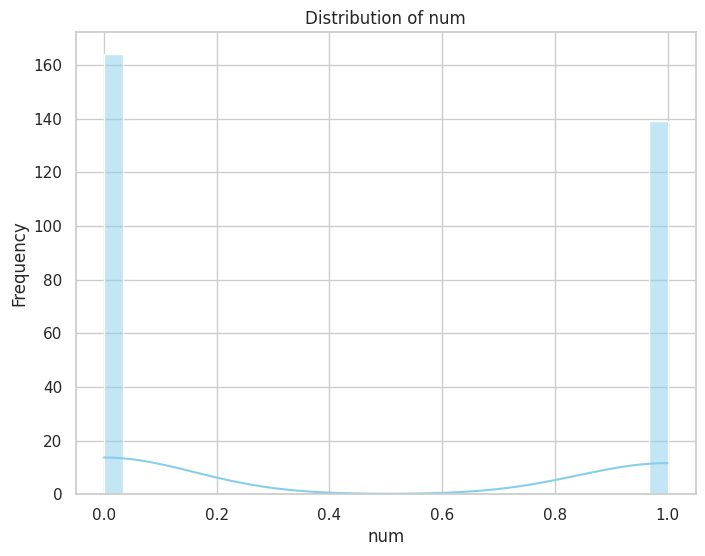

In [ ]:
sns.set(style="whitegrid")

for column in heart.columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=heart, x=column, kde=True, color='skyblue', bins=30)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

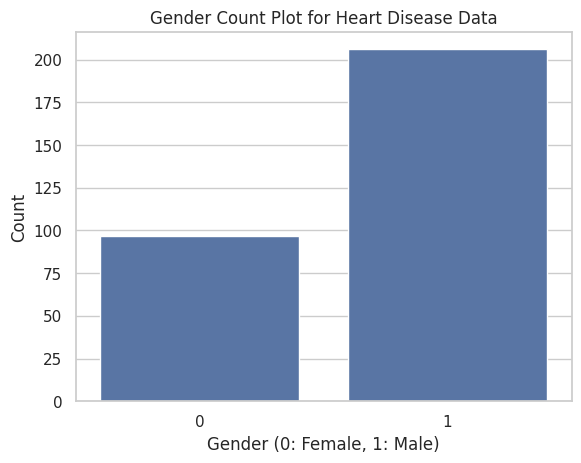

In [ ]:
g = sns.countplot(x='sex', data=heart)
g.set_title("Gender Count Plot for Heart Disease Data")



plt.xlabel("Gender (0: Female, 1: Male)")
plt.ylabel("Count")
plt.show()

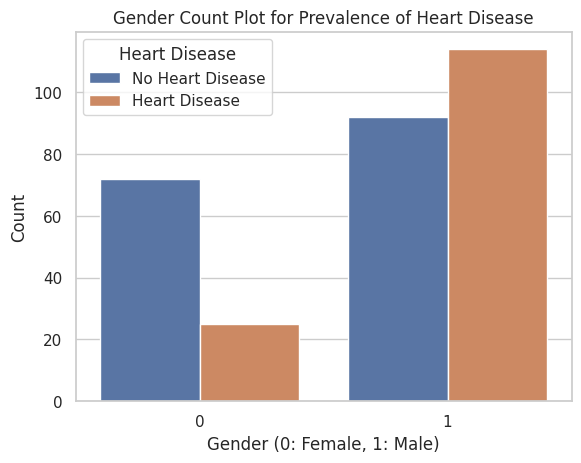

In [ ]:
g = sns.countplot(x='sex', hue='num', data=heart)
g.set_title("Gender Count Plot for Prevalence of Heart Disease")

legend_labels = ['No Heart Disease', 'Heart Disease']
plt.legend(title='Heart Disease', labels=legend_labels)
plt.xlabel("Gender (0: Female, 1: Male)")
plt.ylabel("Count")
plt.show()

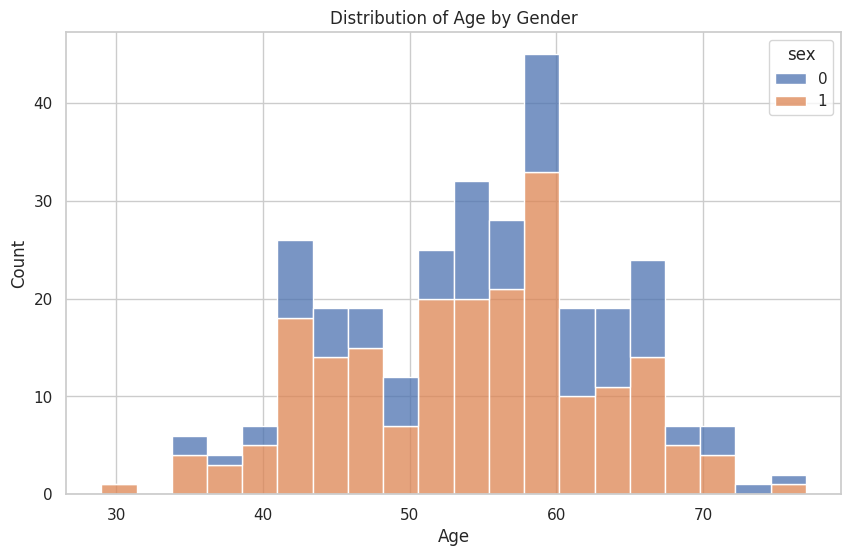

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=heart, x='age', hue='sex', multiple='stack', bins=20)
plt.title('Distribution of Age by Gender')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

### Define Fairness Metrics

In [ ]:
def stat_parity(preds, sens):
    '''
    :preds: numpy array of the model predictions. Consisting of 0s and 1s
    :sens: numpy array of the sensitive features. Consisting of 0s and 1s
    :return: the statistical parity. no need to take the absolute value
    '''
    filter_A = sens == 1
    rstA = sum(preds[filter_A & preds == 1]) / sum(filter_A)

    filter_B = sens == 0
    rstB = sum(preds[filter_B & preds == 1]) / sum(filter_B)
    rst = rstA - rstB
    return abs(rst)

In [ ]:
def eq_oppo(preds, sens, labels):
    '''
    :preds: numpy array of the model predictions. Consisting of 0s and 1s
    :sens: numpy array of the sensitive features. Consisting of 0s and 1s
    :labels: numpy array of the ground truth labels of the outcome. Consisting of 0s and 1s
    :return: the statistical parity. no need to take the absolute value
    '''
    condition_sens0 = np.logical_and(sens == 0, labels == 1)
    condition_sens1 = np.logical_and(sens == 1, labels == 1)

    preds_sens0 = preds[condition_sens0]
    preds_sens1 = preds[condition_sens1]

    preds_sens0 = preds_sens0 if len(preds_sens0) > 0 else 0
    preds_sens1 = preds_sens1 if len(preds_sens1) > 0 else 0
    if len(preds_sens0) > 0 or len(preds_sens1) > 0:
        stat_parity = np.mean(preds_sens1) - np.mean(preds_sens0)
    else: stat_parity = 0

    return stat_parity

In [ ]:
def eval_metric(y_true, y_pred, protect_att):
  rst = [accuracy_score(y_true, y_pred),
         f1_score(y_true, y_pred),
         stat_parity(y_pred, protect_att),
         eq_oppo(y_pred, protect_att, y_true)]
  print(f'accuracy = {rst[0]:.3f}')
  print(f'f1 score = {rst[1]:.3f}')
  print(f'statistical Parity = {rst[2]:.3f}')
  print(f'Equal Opportunity = {rst[3]:.3f}')
  return rst

### Fit regression model on raw data

In [ ]:
X_train_heart, X_test_heart, y_train_heart, y_test_heart = train_test_split(
    heart.iloc[:,:-1], heart.iloc[:,-1], test_size=0.25, random_state=42)

In [ ]:
X_train_heart

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
287,58,1,2,125,220,0,0,144,0,0.4,2,0.672241,7.0
282,55,0,4,128,205,0,1,130,1,2.0,2,1.000000,7.0
197,45,0,4,138,236,0,2,152,1,0.2,2,0.000000,3.0
158,60,1,4,140,293,0,2,170,0,1.2,2,2.000000,7.0
164,48,1,3,124,255,1,0,175,0,0.0,1,2.000000,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,54,1,2,192,283,0,2,195,0,0.0,1,1.000000,7.0
71,67,1,4,125,254,1,0,163,0,0.2,2,2.000000,7.0
106,59,1,4,140,177,0,0,162,1,0.0,1,1.000000,7.0
270,61,1,4,140,207,0,2,138,1,1.9,1,1.000000,7.0


#####logistic model

In [ ]:
reg_heart = LogisticRegression().fit(X_train_heart, y_train_heart)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
reg_heart.feature_names_in_

array(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
       'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal'], dtype=object)

In [ ]:
pred_heart = reg_heart.predict(X_test_heart)

In [ ]:
print('evaluation on logistic regression model for heart disease data')
eval_heart = eval_metric(y_test_heart, pred_heart, X_test_heart['sex'])

evaluation on logistic regression model for heart disease data
accuracy = 0.882
f1 score = 0.880
statistical Parity = 0.271
Equal Opportunity = 0.070


##### decison tree



In [ ]:
dt_heart = DecisionTreeClassifier()
dt_heart.fit(X_train_heart, y_train_heart)
pred_dt_heart = dt_heart.predict(X_test_heart)

print('Evaluation on Decision Tree model for heart disease data')
eval_dt_heart = eval_metric(y_test_heart, pred_dt_heart, X_test_heart['sex'])


Evaluation on Decision Tree model for heart disease data
accuracy = 0.632
f1 score = 0.641
statistical Parity = 0.393
Equal Opportunity = 0.210


#####random forest

In [ ]:
rf_heart = RandomForestClassifier()
rf_heart.fit(X_train_heart, y_train_heart)
pred_rf_heart = rf_heart.predict(X_test_heart)

print('Evaluation on Random Forest model for heart disease data')
eval_rf_heart = eval_metric(y_test_heart, pred_rf_heart, X_test_heart['sex'])

Evaluation on Random Forest model for heart disease data
accuracy = 0.868
f1 score = 0.861
statistical Parity = 0.286
Equal Opportunity = 0.005


### in-processing debiasing using AdversarialDebiasing()
package used:
https://aif360.readthedocs.io/en/stable/modules/generated/aif360.sklearn.inprocessing.AdversarialDebiasing.html#aif360.sklearn.inprocessing.AdversarialDebiasing


In [ ]:
from aif360.sklearn.datasets import standardize_dataset

In [ ]:
sess = tf.Session()

##### logistic model

In [ ]:
# trainform data
heart_train = X_train_heart.copy()
heart_train['num'] = y_train_heart
heart_ad = standardize_dataset(heart_train, prot_attr='sex', target='num')

In [ ]:
heart_ad

Dataset(X=     age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
sex                                                                        
1     58    1   2       125   220    0        0      144      0      0.4   
0     55    0   4       128   205    0        1      130      1      2.0   
0     45    0   4       138   236    0        2      152      1      0.2   
1     60    1   4       140   293    0        2      170      0      1.2   
1     48    1   3       124   255    1        0      175      0      0.0   
..   ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
1     54    1   2       192   283    0        2      195      0      0.0   
1     67    1   4       125   254    1        0      163      0      0.2   
1     59    1   4       140   177    0        0      162      1      0.0   
1     61    1   4       140   207    0        2      138      1      1.9   
0     57    0   4       128   303    0        2      159      0      0.0   

 

In [ ]:
ad = AdversarialDebiasing(debias=True)
ad.fit(heart_ad.X, heart_ad.y)

AdversarialDebiasing()

In [ ]:
ad.prot_attr_

FrozenList(['sex'])

In [ ]:
pred_debias_heart = ad.predict(X_test_heart)

In [ ]:
print('evaluation on logistic regression model for heart disease data using AdversarialDebiasing()')
eval_heart_ad = eval_metric(y_test_heart, pred_debias_heart, X_test_heart['sex'])

evaluation on logistic regression model for heart disease data using AdversarialDebiasing()
accuracy = 0.697
f1 score = 0.657
statistical Parity = 0.075
Equal Opportunity = -0.285


##### decision tree

In [ ]:
dt_ad = DecisionTreeClassifier()
dt_ad.fit(heart_ad.X, heart_ad.y)
pred_dt_ad = dt_ad.predict(X_test_heart)

print('Evaluation on Decision Tree model for heart disease data using AdversarialDebiasing')
eval_dt_ad = eval_metric(y_test_heart, pred_dt_ad, X_test_heart['sex'])


Evaluation on Decision Tree model for heart disease data using AdversarialDebiasing
accuracy = 0.671
f1 score = 0.691
statistical Parity = 0.446
Equal Opportunity = 0.306


#####random forest

In [ ]:
rf_ad = RandomForestClassifier()
rf_ad.fit(heart_ad.X, heart_ad.y)
pred_rf_ad = rf_ad.predict(X_test_heart)

print('Evaluation on Random Forest model for heart disease data using AdversarialDebiasing')
eval_rf_ad = eval_metric(y_test_heart, pred_rf_ad, X_test_heart['sex'])

Evaluation on Random Forest model for heart disease data using AdversarialDebiasing
accuracy = 0.868
f1 score = 0.865
statistical Parity = 0.321
Equal Opportunity = 0.038


### preprocessing mitigate bias

#### remove protected attribute

In [ ]:
X_train_heart

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
287,58,1,2,125,220,0,0,144,0,0.4,2,0.672241,7.0
282,55,0,4,128,205,0,1,130,1,2.0,2,1.000000,7.0
197,45,0,4,138,236,0,2,152,1,0.2,2,0.000000,3.0
158,60,1,4,140,293,0,2,170,0,1.2,2,2.000000,7.0
164,48,1,3,124,255,1,0,175,0,0.0,1,2.000000,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,54,1,2,192,283,0,2,195,0,0.0,1,1.000000,7.0
71,67,1,4,125,254,1,0,163,0,0.2,2,2.000000,7.0
106,59,1,4,140,177,0,0,162,1,0.0,1,1.000000,7.0
270,61,1,4,140,207,0,2,138,1,1.9,1,1.000000,7.0


#####logistic model

In [ ]:
reg_heart_rm = LogisticRegression().fit(X_train_heart.loc[:, X_train_heart.columns != 'sex'], y_train_heart)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
pred_heart_rm = reg_heart_rm.predict(X_test_heart.loc[:, X_test_heart.columns != 'sex'])

In [ ]:
print('evaluation on logistic regression model for heart disease data after removing protected attribute "sex"')
eval_heart_rm = eval_metric(y_test_heart, pred_heart_rm, X_test_heart['sex'])

evaluation on logistic regression model for heart disease data after removing protected attribute "sex"
accuracy = 0.855
f1 score = 0.853
statistical Parity = 0.204
Equal Opportunity = 0.038


In [ ]:
reg_heart_rm.feature_names_in_

array(['age', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'], dtype=object)

#####decision tree

In [ ]:
dt_heart_rm = DecisionTreeClassifier()
dt_heart_rm.fit(X_train_heart.drop('sex', axis=1), y_train_heart)
pred_dt_heart_rm = dt_heart_rm.predict(X_test_heart.drop('sex', axis=1))

print('Evaluation on Decision Tree model for heart disease data after removing protected attribute "sex"')
eval_dt_heart_rm = eval_metric(y_test_heart, pred_dt_heart_rm, X_test_heart['sex'])


Evaluation on Decision Tree model for heart disease data after removing protected attribute "sex"
accuracy = 0.711
f1 score = 0.711
statistical Parity = 0.086
Equal Opportunity = -0.323


#####random forest

In [ ]:
rf_heart_rm = RandomForestClassifier()
rf_heart_rm.fit(X_train_heart.drop('sex', axis=1), y_train_heart)
pred_rf_heart_rm = rf_heart_rm.predict(X_test_heart.drop('sex', axis=1))

print('Evaluation on Random Forest model for heart disease data after removing protected attribute "sex"')
eval_rf_heart_rm = eval_metric(y_test_heart, pred_rf_heart_rm, X_test_heart['sex'])

Evaluation on Random Forest model for heart disease data after removing protected attribute "sex"
accuracy = 0.855
f1 score = 0.849
statistical Parity = 0.236
Equal Opportunity = 0.005


#### Augmenting the training set
[source link](https://krvarshney.github.io/pubs/SharmaZRBMV_aies2020.pdf://)

In [ ]:
X_train_heart_syn = X_train_heart.copy()
y_train_heart_syn = y_train_heart.copy()

X_train_heart_syn['sex'] = X_train_heart_syn['sex'].map({1: 0, 0: 1})


X_train_heart_aug = pd.concat((X_train_heart, X_train_heart_syn))
y_train_heart_aug = pd.concat((y_train_heart, y_train_heart_syn))

In [ ]:
X_train_heart_aug.shape

(454, 13)

##### logistic model

In [ ]:
reg_heart_aug = LogisticRegression().fit(X_train_heart_aug, y_train_heart_aug)
pred_heart_aug = reg_heart_aug.predict(X_test_heart)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
print('evaluation on logistic regression model for heart disease data after data augmentation')
eval_heart_aug = eval_metric(y_test_heart, pred_heart_aug, X_test_heart['sex'])

evaluation on logistic regression model for heart disease data after data augmentation
accuracy = 0.868
f1 score = 0.868
statistical Parity = 0.221
Equal Opportunity = 0.070


##### decision tree

In [ ]:
dt_heart_aug = DecisionTreeClassifier()
dt_heart_aug.fit(X_train_heart_aug, y_train_heart_aug)
pred_dt_heart_aug = dt_heart_aug.predict(X_test_heart)

print('Evaluation on Decision Tree model for heart disease data after data augmentation')
eval_dt_heart_aug = eval_metric(y_test_heart, pred_dt_heart_aug, X_test_heart['sex'])


Evaluation on Decision Tree model for heart disease data after data augmentation
accuracy = 0.711
f1 score = 0.718
statistical Parity = 0.121
Equal Opportunity = -0.290


##### random forest

In [ ]:
rf_heart_aug = RandomForestClassifier()
rf_heart_aug.fit(X_train_heart_aug, y_train_heart_aug)
pred_rf_heart_aug = rf_heart_aug.predict(X_test_heart)

print('Evaluation on Random Forest model for heart disease data after data augmentation')
eval_rf_heart_aug = eval_metric(y_test_heart, pred_rf_heart_aug, X_test_heart['sex'])

Evaluation on Random Forest model for heart disease data after data augmentation
accuracy = 0.855
f1 score = 0.849
statistical Parity = 0.236
Equal Opportunity = 0.005


#### SMOTE algorithm

In [ ]:

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_heart_smote, y_train_heart_smote = smote.fit_resample(X_train_heart, y_train_heart)
reg_heart_smote = LogisticRegression().fit(X_train_heart_smote, y_train_heart_smote)
pred_heart_smote = reg_heart_smote.predict(X_test_heart)

print('Evaluation on logistic regression model for heart disease data after using SMOTE:')
eval_heart_smote = eval_metric(y_test_heart, pred_heart_smote, X_test_heart['sex'])


Evaluation on logistic regression model for heart disease data after using SMOTE:
accuracy = 0.868
f1 score = 0.868
statistical Parity = 0.221
Equal Opportunity = 0.070


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


##### Train SVM model

In [ ]:
from sklearn.svm import SVC

svm_heart_smote = SVC(kernel='linear').fit(X_train_heart_smote, y_train_heart_smote)
pred_heart_svm_smote = svm_heart_smote.predict(X_test_heart)
print('Evaluation on SVM model for heart disease data after using SMOTE:')
eval_heart_svm_smote = eval_metric(y_test_heart, pred_heart_svm_smote, X_test_heart['sex'])


Evaluation on SVM model for heart disease data after using SMOTE:
accuracy = 0.855
f1 score = 0.857
statistical Parity = 0.171
Equal Opportunity = 0.070


### metrics evaluation

In [ ]:
eval_combine = [eval_heart, eval_heart_ad, eval_heart_aug, eval_heart_rm, eval_dt_heart, eval_dt_ad, eval_dt_heart_aug, eval_dt_heart_rm, eval_rf_heart, eval_rf_ad, eval_rf_heart_aug, eval_rf_heart_rm, eval_heart_smote, eval_heart_svm_smote]

In [ ]:
eval_df = pd.DataFrame(eval_combine, columns=['accuracy', 'f1', 'stat_parity', 'equal_oppo'])

In [ ]:
eval_df['method'] = ['Logisitc-raw', 'Logisitc-AdvDebia', 'Logistic-augment', 'Logistic-removeFeature', 'DecisonTree-raw', 'DecisonTree-AdvDebia', 'DecisonTree-augment', 'DecisonTree-removeFeature', 'RandomForest-raw', 'RandomForest-AdvDebia', 'RandomForest-augment', 'RandomForest-removeFeature', 'SMOTE', 'SMOTE-SVM']

In [ ]:
eval_df

,accuracy,f1,stat_parity,equal_oppo,method
0,0.881579,0.880000,0.271429,0.069892,Logisitc-raw
1,0.697368,0.656716,0.075000,-0.284946,Logisitc-AdvDebia
2,0.868421,0.868421,0.221429,0.069892,Logistic-augment
3,0.855263,0.853333,0.203571,0.037634,Logistic-removeFeature
4,0.631579,0.641026,0.392857,0.209677,DecisonTree-raw
5,0.671053,0.691358,0.446429,0.306452,DecisonTree-AdvDebia
6,0.710526,0.717949,0.121429,-0.290323,DecisonTree-augment
7,0.710526,0.710526,0.085714,-0.322581,DecisonTree-removeFeature
8,0.868421,0.861111,0.285714,0.005376,RandomForest-raw
9,0.868421,0.864865,0.321429,0.037634,RandomForest-AdvDebia


In [ ]:
eval_df.round(4)

,accuracy,f1,stat_parity,equal_oppo,method
0,0.8816,0.8800,0.2714,0.0699,Logisitc-raw
1,0.6974,0.6567,0.0750,-0.2849,Logisitc-AdvDebia
2,0.8684,0.8684,0.2214,0.0699,Logistic-augment
3,0.8553,0.8533,0.2036,0.0376,Logistic-removeFeature
4,0.6316,0.6410,0.3929,0.2097,DecisonTree-raw
5,0.6711,0.6914,0.4464,0.3065,DecisonTree-AdvDebia
6,0.7105,0.7179,0.1214,-0.2903,DecisonTree-augment
7,0.7105,0.7105,0.0857,-0.3226,DecisonTree-removeFeature
8,0.8684,0.8611,0.2857,0.0054,RandomForest-raw
9,0.8684,0.8649,0.3214,0.0376,RandomForest-AdvDebia


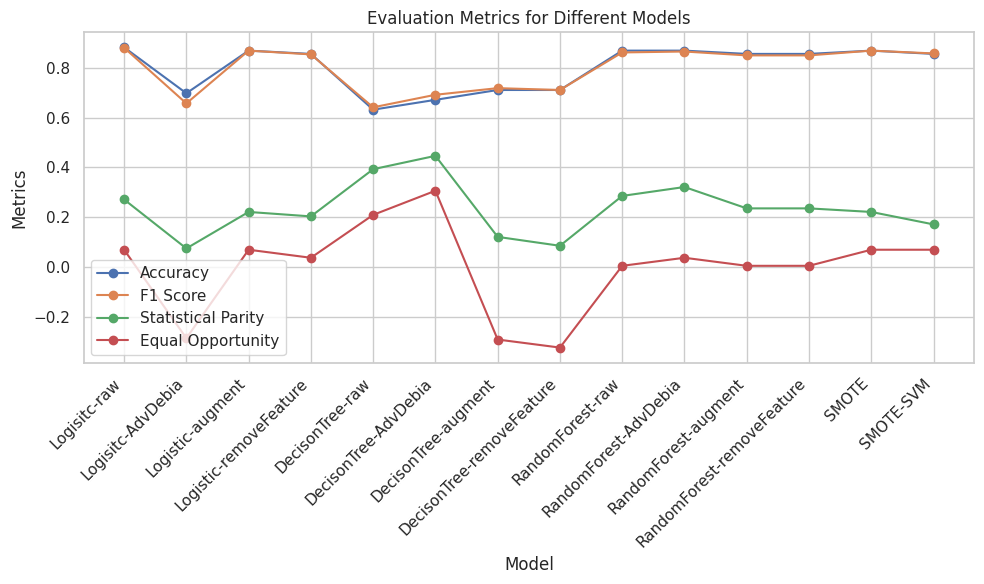

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(eval_df['method'], eval_df['accuracy'], marker='o', label='Accuracy')
plt.plot(eval_df['method'], eval_df['f1'], marker='o', label='F1 Score')
plt.plot(eval_df['method'], eval_df['stat_parity'], marker='o', label='Statistical Parity')
plt.plot(eval_df['method'], eval_df['equal_oppo'], marker='o', label='Equal Opportunity')

plt.xlabel('Model')
plt.ylabel('Metrics')
plt.title('Evaluation Metrics for Different Models')
plt.xticks(rotation=45, ha='right')
plt.legend()

plt.tight_layout()
plt.grid(True)
plt.show()